In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
## Load data
month_data_no_census = np.load('../data/covid/covid_month_no_census_filtered.npy', allow_pickle=True)
month_data_with_census = np.load('../data/covid/covid_month_with_census_filtered.npy',allow_pickle=True)
print(month_data_no_census.shape, month_data_with_census.shape)
month_data_df = pd.read_csv('../data/covid/covid_month.csv')
month_data_df.head()

(312, 5) (312, 172)


,Unnamed: 0,month,region,cases
0,0,3,Acton,0
1,1,3,Adams-Normandie,5
2,2,3,Agoura Hills,56
3,3,3,Alhambra,90
4,4,3,Alsace,0


# Naive train-test split

In [3]:
month_no_census_X = month_data_no_census[:, 1:]
month_no_census_X = month_no_census_X[:,:-1]
month_no_census_y = month_data_no_census[:, -1]

month_with_census_X = month_data_with_census[:, 1:]
month_with_census_X = month_with_census_X[:,:-1]
month_with_census_y = month_data_with_census[:, -1]

print(month_no_census_X.shape, month_with_census_X.shape)

(1110, 3) (1110, 170)


In [4]:
month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test = train_test_split(
    month_no_census_X, month_no_census_y, test_size=0.4, random_state=42)
month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test = train_test_split(
    month_with_census_X, month_with_census_y, test_size=0.4, random_state=42)

# Time Validation

In [5]:
def one_time_split(data):
    # Index of first row with month == 4
    first_index = np.where(data[:,0]==4)[0][0]
    print(first_index)
    # Index of first row with month == 8
    last_index = np.where(data[:,0] == 8)[0][0]
    
    # Split into train test
    X_train = data[first_index:last_index, 1:-1]
    X_test = data[last_index:, 1:-1]
    y_train = data[first_index:last_index, -1]
    y_test = data[last_index:, -1]
    
    return(X_train,X_test,y_train,y_test)

In [6]:
def multiple_time_split(data):
    X_train_arr = []
    X_test_arr = []
    y_train_arr = []
    y_test_arr = []
    for i in range(4,7):
        train_start_index = np.where(data[:,0]==i)[0][0]
        test_start_index = np.where(data[:,0]==i+2)[0][0]
        test_end_index = np.where(data[:,0]==i+3)[0][0] if i!=6 else data.shape[0]
        X_train = data[train_start_index:test_start_index, 1:-1]
        X_test = data[test_start_index:test_end_index, 1:-1]
        y_train = data[train_start_index:test_start_index, -1]
        y_test = data[test_start_index:test_end_index, -1]
        
        print('============')
        print(train_start_index, test_start_index, test_end_index)
        print('============')
        
        X_train_arr.append(X_train)
        X_test_arr.append(X_test)
        y_train_arr.append(y_train)
        y_test_arr.append(y_test)
        
    return (X_train_arr, X_test_arr, y_train_arr, y_test_arr)

In [7]:
month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test = one_time_split(
    month_data_no_census)
print(month_no_census_X_test.shape)

52
(52, 3)


In [8]:
month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test = one_time_split(
    month_data_with_census)
print(month_with_census_X_test.shape)

52
(52, 170)


In [9]:
month_no_census_X_train_arr, month_no_census_X_test_arr, month_no_census_y_train_arr, month_no_census_y_test_arr = multiple_time_split(
    month_data_no_census)
print(month_no_census_X_train_arr[1].shape)

52 156 208
104 208 260
156 260 312
(104, 3)


In [10]:
print(month_no_census_y_test_arr[1].shape)

(52,)


In [11]:
month_with_census_X_train_arr, month_with_census_X_test_arr, month_with_census_y_train_arr, month_with_census_y_test_arr = multiple_time_split(
    month_data_with_census)
print(month_with_census_X_train_arr[2].shape)

52 156 208
104 208 260
156 260 312
(104, 170)


In [12]:
def one_split_model(X_train, X_test, y_train, y_test, model, graph_title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    r2 = r2_score(y_pred, y_test)
    mae = mean_absolute_error(y_pred, y_test)
    print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=mse, b=r2, c=mae, d=np.average(y_test)))
    fig, ax = plt.subplots(figsize=[8,6])
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title(graph_title)
    plt.show()

In [13]:
def multiple_split_model(X_train_arr, X_test_arr, y_train_arr, y_test_arr, model, graph_title):
    y_pred_arr = []
    mse_arr = []
    r2_arr = []
    mae_arr = []
    avg_arr = []

    for i in range(len(X_train_arr)):
        model.fit(X_train_arr[i], y_train_arr[i])
        y_pred_arr.append(model.predict(X_test_arr[i]))
        mse_arr.append(mean_squared_error(y_pred_arr[i], y_test_arr[i]))
        r2_arr.append(r2_score(y_pred_arr[i], y_test_arr[i]))
        mae_arr.append(mean_absolute_error(y_pred_arr[i], y_test_arr[i]))
        avg_arr.append(np.average(y_test_arr[i]))
    print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=mse_arr, b=r2_arr, c=mae_arr, d=avg_arr))
    fig, axs = plt.subplots(len(avg_arr), figsize=[8,12], constrained_layout=True)
    for i in range(len(avg_arr)):
        axs[i].scatter(y_test_arr[i], y_pred_arr[i])
        axs[i].plot([y_test_arr[i].min(), y_test_arr[i].max()], [y_test_arr[i].min(), y_test_arr[i].max()], 'k--', lw=4)
        axs[i].set_xlabel('Measured')
        axs[i].set_ylabel('Predicted')
        axs[i].set_title('Prediction for month {m}'.format(m=i+5))
    fig.suptitle(graph_title, fontsize=16)
    plt.show()

# Linear Reg

In [17]:
lin_model_no_census = LinearRegression()
lin_model_no_census.fit(month_no_census_X_train, month_no_census_y_train)
lin_model_with_census = LinearRegression()
lin_model_with_census.fit(month_with_census_X_train, month_with_census_y_train)

LinearRegression()

In [18]:
month_no_census_y_lin_pred = lin_model_no_census.predict(month_no_census_X_test)
month_no_census_lin_mse = mean_squared_error(month_no_census_y_lin_pred, month_no_census_y_test)
month_with_census_y_lin_pred = lin_model_with_census.predict(month_with_census_X_test)
month_with_census_lin_mse = mean_squared_error(month_with_census_y_lin_pred, month_with_census_y_test)
print(month_no_census_lin_mse, month_with_census_lin_mse)

403382112.59846675 414776929.8841622


# SVR

In [36]:
svr_params = {
#     'degree': 1,
#     'kernel': 'linear'
    'loss':'squared_epsilon_insensitive',
    'C': 0.6,
    'max_iter': 100000
}

MSE: 1184187611.7744863 
r2: 0.7430458512791352 
MAE: 21997.95823870749 
avg: 34373.33513513514


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


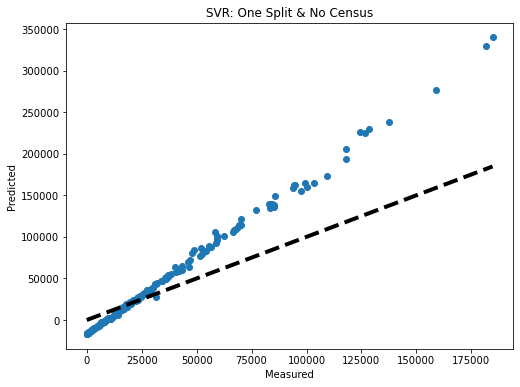

In [37]:
svr_model = LinearSVR(**svr_params)
one_split_model(month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test, svr_model, "SVR: One Split & No Census")

MSE: [674678528.874173, 1506749527.0580342, 1698876485.0511403] 
r2: [-814269474183.6931, -905190685081.8055, -207611829990.8173] 
MAE: [16527.17168725173, 24305.19115092348, 25838.691708802937] 
avg: [19915.90810810811, 30415.097297297296, 34373.33513513514]


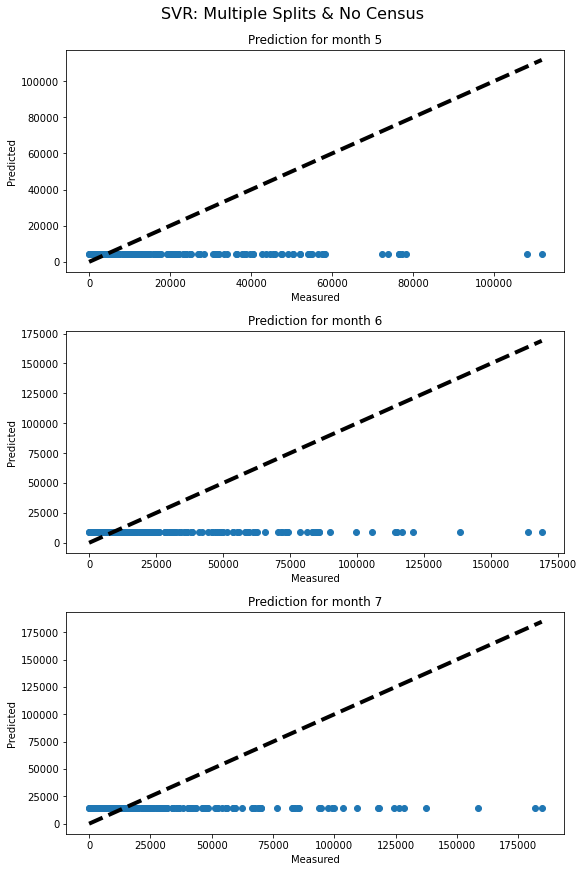

In [31]:
multiple_split_model(month_no_census_X_train_arr, month_no_census_X_test_arr, month_no_census_y_train_arr, month_no_census_y_test_arr, svr_model, "SVR: Multiple Splits & No Census")

# Gradient Boosting

In [14]:
gb_params = {'n_estimators': 1000,
          'max_depth': 32,
          'min_samples_split': 100,
          'learning_rate': 0.01,
          'loss': 'ls'}
gb_model = GradientBoostingRegressor(**gb_params)

## One split

### No census

MSE: 234558182.08104977 
r2: 0.8650913586859393 
MAE: 11645.038297522538 
avg: 35071.903846153844


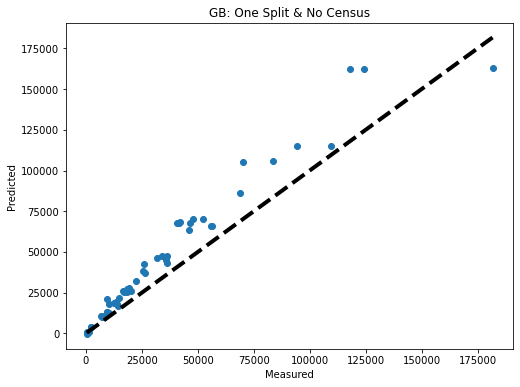

In [15]:
one_split_model(month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test, gb_model, "GB: One Split & No Census")

### With census

MSE: 179086562.87162587 
r2: 0.8896715191749001 
MAE: 10358.05490302437 
avg: 35071.903846153844


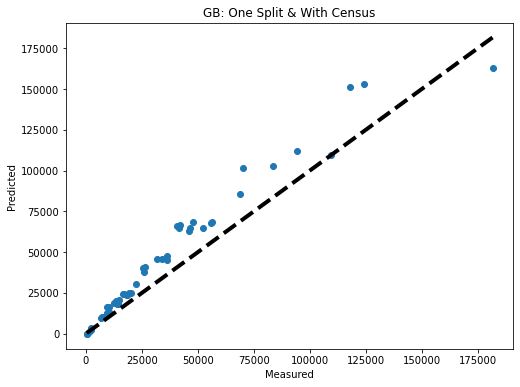

In [16]:
one_split_model(month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test, gb_model, "GB: One Split & With Census")

## Multiple Splits

### No census

MSE: [113864879.16097786, 210096640.38290352, 239380677.0465945] 
r2: [0.5759577011875692, 0.8031715967841653, 0.8615483160030657] 
MAE: [5143.593770068993, 9251.71089602665, 11843.99308411982] 
avg: [20526.423076923078, 31043.634615384617, 35071.903846153844]


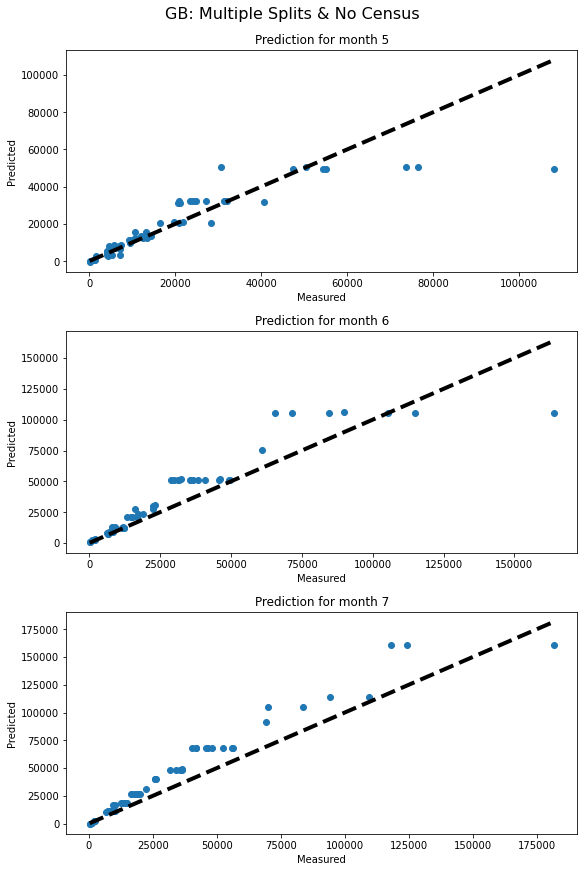

In [17]:
multiple_split_model(month_no_census_X_train_arr, month_no_census_X_test_arr, month_no_census_y_train_arr, month_no_census_y_test_arr, gb_model, "GB: Multiple Splits & No Census")

### With census

MSE: [115227070.82566476, 179904846.1928382, 179247865.05866134] 
r2: [0.506657315253498, 0.8256278435412722, 0.8845842442726325] 
MAE: [5030.893061286206, 8287.83543907518, 10639.89353184358] 
avg: [20526.423076923078, 31043.634615384617, 35071.903846153844]


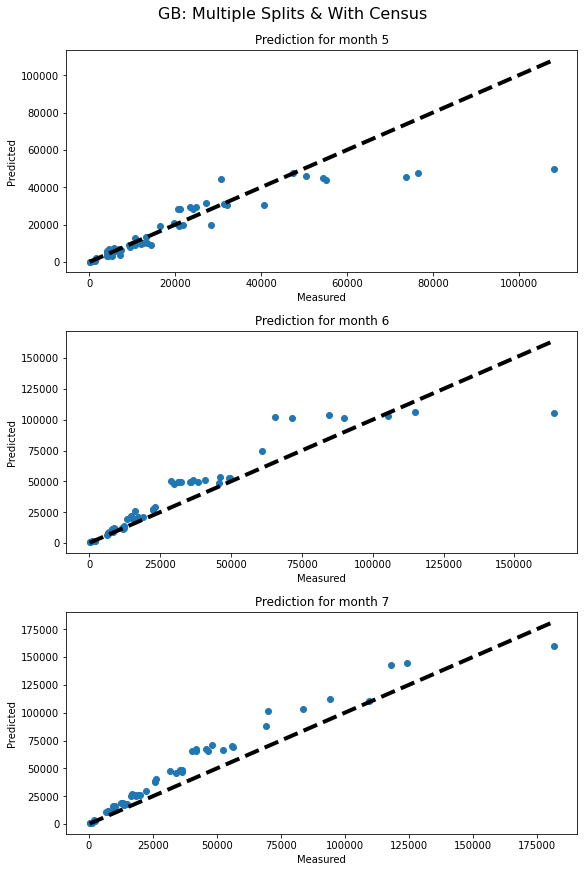

In [18]:
multiple_split_model(month_with_census_X_train_arr, month_with_census_X_test_arr, month_with_census_y_train_arr, month_with_census_y_test_arr, gb_model, "GB: Multiple Splits & With Census")